<a href="https://colab.research.google.com/github/NajouaMardi/sentiment-analysis/blob/master/app/SentimentA%20(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
#connecting to kaggle
'''!pip install -q kaggle
from google.colab import files
files.upload()  # upload kaggle.json from your Kaggle API account
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Replace 'username/dataset-name' with your actual path
!kaggle datasets download -d najouamardi/sample_labeled_sentiment
!unzip sample_labeled_sentiment.zip

Saving kaggle.json to kaggle (14).json
403 Client Error: Forbidden for url: https://www.kaggle.com/api/v1/datasets/metadata/najouamardi/processed-reviews
unzip:  cannot find or open processed-reviews.zip, processed-reviews.zip.zip or processed-reviews.zip.ZIP.


In [2]:
#df = pd.read_csv('sample_labeled_sentiment.csv')
df = pd.read_csv('processed_reviews_50k.csv')
df.head()


,rating,title,text,timestamp,helpful_vote,verified_purchase,label,full_text,sentiment
0,1.0,malware,mcaffee IS malware,1562182632076,0,0,negative,malware mcaffee is malware,negative
1,5.0,Lots of Fun,I love playing tapped out because it is fun to...,1424120336000,0,1,positive,lots of fun i love playing tapped out because ...,positive
2,5.0,Light Up The Dark,I love this flashlight app! It really illumin...,1362399267000,0,1,positive,light up the dark i love this flashlight app i...,positive
3,4.0,Fun game,One of my favorite games,1561061428662,0,1,positive,fun game one of my favorite games,positive
4,4.0,I am not that good at it but my kids are,Cute game. I am not that good at it but my kid...,1418257196000,0,1,positive,i am not that good at it but my kids are cute ...,positive


In [3]:
print("shape ",df.shape)
print("checking if data is missing",df.isnull().sum())
print("data types of columns",df.dtypes)

shape  (50000, 9)
checking if data is missing rating                0
title                28
text                 19
timestamp             0
helpful_vote          0
verified_purchase     0
label                 0
full_text             0
sentiment             0
dtype: int64
data types of columns rating               float64
title                 object
text                  object
timestamp              int64
helpful_vote           int64
verified_purchase      int64
label                 object
full_text             object
sentiment             object
dtype: object


In [4]:
#to drop empty lines with empty text or title
df_clean = df.dropna(subset=['title', 'text'])

In [5]:
print("shape after cleaning ",df_clean.shape)
print("checking if data is missing now",df_clean.isnull().sum())

shape after cleaning  (49962, 9)
checking if data is missing now rating               0
title                0
text                 0
timestamp            0
helpful_vote         0
verified_purchase    0
label                0
full_text            0
sentiment            0
dtype: int64


In [6]:
#Summary statistics for numeric columns
df_clean.describe()

,rating,timestamp,helpful_vote,verified_purchase
count,49962.000000,4.996200e+04,49962.000000,49962.000000
mean,3.824747,1.484368e+12,3.912934,0.946820
std,1.484705,9.004306e+10,19.409004,0.224395
min,1.000000,9.517750e+11,0.000000,0.000000
25%,3.000000,1.421414e+12,0.000000,1.000000
50%,5.000000,1.478924e+12,0.000000,1.000000
75%,5.000000,1.553951e+12,2.000000,1.000000
max,5.000000,1.679170e+12,2085.000000,1.000000


In [7]:
# Check the value counts of relevant categorical columns (e.g., "rating", "helpfulness")
df_clean['rating'].value_counts()

,count
rating,
5.0,25699
4.0,8038
1.0,7526
3.0,5521
2.0,3178


In [9]:
rating_counts = df_clean["rating"].value_counts().sort_index()
rating_percentages = (rating_counts / rating_counts.sum()) * 100

# Display nicely
rating_distribution = pd.DataFrame({
    "count": rating_counts,
    "percentage": rating_percentages.round(2)
})

print(rating_distribution)

        count  percentage
rating                   
1.0      7526       15.06
2.0      3178        6.36
3.0      5521       11.05
4.0      8038       16.09
5.0     25699       51.44


<Axes: title={'center': 'Distribution of Ratings'}, xlabel='rating'>

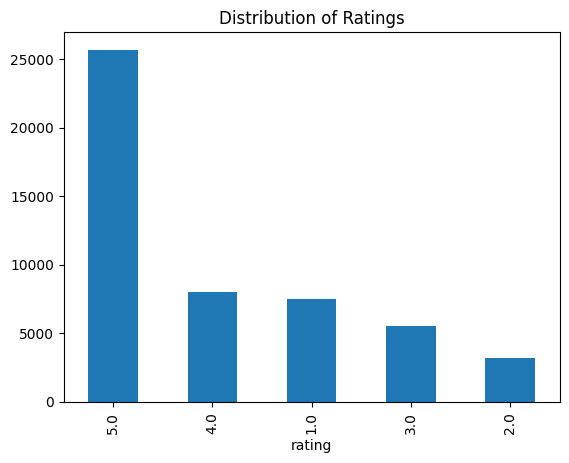

In [10]:
# If the dataset has a rating column or sentiment labels, explore their distribution
df_clean['rating'].value_counts().plot(kind='bar', title='Distribution of Ratings')

In [11]:
sentiment_counts = df_clean["sentiment"].value_counts()
sentiment_percentages = (sentiment_counts / len(df)) * 100
sentiment_summary = pd.DataFrame({
    "count": sentiment_counts,
    "percentage": sentiment_percentages.round(2)
})
print(sentiment_summary)

           count  percentage
sentiment                   
positive   32140       64.28
negative   11602       23.20
neutral     6220       12.44


In [ ]:
###Text preprocessing (applied on full_text (title and text)):
 ##Lowercase the text
 ##Remove punctuation and non-alphabetic characters
 ##Remove stop words

In [12]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
#stemmer = PorterStemmer()

def preprocess(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize and remove stop words
    tokens = [word for word in text.split() if word not in stop_words]
    # Stemming
    #stemmed = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)

# Apply to full_text (title+text)
df_clean['clean_full_text'] = df_clean['full_text'].apply(preprocess)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
<ipython-input-12-e4c3f13c0a47>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['clean_full_text'] = df_clean['full_text'].apply(preprocess)


In [13]:
df_clean[:50]

,rating,title,text,timestamp,helpful_vote,verified_purchase,label,full_text,sentiment,clean_full_text
0,1.0,malware,mcaffee IS malware,1562182632076,0,0,negative,malware mcaffee is malware,negative,malware mcaffee malware
1,5.0,Lots of Fun,I love playing tapped out because it is fun to...,1424120336000,0,1,positive,lots of fun i love playing tapped out because ...,positive,lots fun love playing tapped fun watch town gr...
2,5.0,Light Up The Dark,I love this flashlight app! It really illumin...,1362399267000,0,1,positive,light up the dark i love this flashlight app i...,positive,light dark love flashlight app really illumina...
3,4.0,Fun game,One of my favorite games,1561061428662,0,1,positive,fun game one of my favorite games,positive,fun game one favorite games
4,4.0,I am not that good at it but my kids are,Cute game. I am not that good at it but my kid...,1418257196000,0,1,positive,i am not that good at it but my kids are cute ...,positive,good kids cute game good kids love nik wallenda
5,4.0,good game,"Made me think , variety of the puzzles kept it...",1374994387000,0,1,positive,good game made me think variety of the puzzles...,positive,good game made think variety puzzles kept fun ...
6,5.0,My favorite showVoice my favorite show,See the voice anytime my My favorite show,1520456160247,0,1,positive,my favorite showvoice my favorite show see the...,positive,favorite showvoice favorite show see voice any...
7,5.0,Great Antivirus product,Not sure what else can be said about Norton pr...,1384358113000,0,0,positive,great antivirus product not sure what else can...,positive,great antivirus product sure else said norton ...
8,1.0,Fraught with too many problems,Save your money and purchase a good (i.e. Nort...,1366378695000,0,0,negative,fraught with too many problems save your money...,negative,fraught many problems save money purchase good...
9,4.0,Norton Internet Security,I always use Norton as my PC security applicat...,1365671303000,0,0,positive,norton internet security i always use norton a...,positive,norton internet security always use norton pc ...


In [14]:
X = df_clean['clean_full_text']
y = df_clean['sentiment']

In [ ]:
# Split your data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

f1_scorer = make_scorer(f1_score, pos_label='positive')

# Define the pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('chi2', SelectKBest(score_func=chi2)),    ###Chi-Squared Test (chi²): A statistical test that can be used to evaluate the importance of each feature for classification.
    ('clf', LinearSVC())
])

# Hyperparameters to tune
param_grid = {
    'tfidf__max_features': [4000, 5000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'chi2__k': [2000, 3000],
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__max_iter': [1000, 3000]
}

# Grid search using F1 score
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring=f1_scorer, n_jobs=-1)
grid.fit(X_train, y_train)

# Predictions on test set
y_pred = grid.predict(X_test)

# Print best parameters (based on F1)
print("Best max_features (TF-IDF):", grid.best_params_['tfidf__max_features'])
print("Best ngram_range (TF-IDF):", grid.best_params_['tfidf__ngram_range'])
print("Best k (SelectKBest):", grid.best_params_['chi2__k'])
print("Best C (LinearSVC):", grid.best_params_['clf__C'])
print("Best parameters (F1 score):", grid.best_score_)

# Show both F1 and Accuracy on the test set
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test F1 Score (macro):", f1_score(y_test, y_pred, average='binary', pos_label='positive'))


Best max_features (TF-IDF): 5000
Best ngram_range (TF-IDF): (1, 2)
Best k (SelectKBest): 3000
Best C (LinearSVC): 0.1
Best parameters (F1 score): 0.9132283593070916
Test Accuracy: 0.8844133099824869
Test F1 Score (macro): 0.9126323751891074


<pre>
<h2>Results with Chi-2</h2>
Best max_features (TF-IDF): 5000
Best ngram_range (TF-IDF): (1, 2)
Best k (SelectKBest): 3000
Best C (LinearSVC): 0.1
Best parameters (F1 score): 0.9132283593070916
Test Accuracy: 0.8844133099824869
Test F1 Score (macro): 0.9126323751891074
</pre>

In [ ]:
# Split your data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

f1_scorer = make_scorer(f1_score, pos_label='positive')

# Define the pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    #('chi2', SelectKBest(score_func=chi2)),    ###Chi-Squared Test (chi²): A statistical test that can be used to evaluate the importance of each feature for classification.
    ('clf', LinearSVC())
])

# Hyperparameters to tune
param_grid = {
    'tfidf__max_features': [4000, 5000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    #'chi2__k': [2000, 3000],
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__max_iter': [1000, 3000]
}

# Grid search using F1 score
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring=f1_scorer, n_jobs=-1)
grid.fit(X_train, y_train)

# Predictions on test set
y_pred = grid.predict(X_test)

# Print best parameters (based on F1)
print("Best max_features (TF-IDF):", grid.best_params_['tfidf__max_features'])
print("Best ngram_range (TF-IDF):", grid.best_params_['tfidf__ngram_range'])
#print("Best k (SelectKBest):", grid.best_params_['chi2__k'])
print("Best C (LinearSVC):", grid.best_params_['clf__C'])
print("Best parameters (F1 score):", grid.best_score_)

# Show both F1 and Accuracy on the test set
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test F1 Score (macro):", f1_score(y_test, y_pred, average='binary', pos_label='positive'))


Best max_features (TF-IDF): 5000
Best ngram_range (TF-IDF): (1, 2)
Best C (LinearSVC): 0.1
Best parameters (F1 score): 0.9159339396537017
Test Accuracy: 0.8882161621215912
Test F1 Score (macro): 0.9156981132075471


<pre>
<h2>Results without Chi-2</h2>
Best max_features (TF-IDF): 5000
Best ngram_range (TF-IDF): (1, 2)
Best C (LinearSVC): 0.1
Best parameters (F1 score): 0.9159339396537017
Test Accuracy: 0.8882161621215912
Test F1 Score (macro): 0.9156981132075471
</pre>

In [21]:
# Split your data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#f1_scorer = make_scorer(f1_score, average='weighted')

# Define the pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('chi2', SelectKBest(score_func=chi2)),    ###Chi-Squared Test (chi²): A statistical test that can be used to evaluate the importance of each feature for classification.
    ('clf', LinearSVC(class_weight='balanced'))    #('clf', LinearSVC(class_weight='balanced'))
])

# Hyperparameters to tune
param_grid = {
    'tfidf__max_features': [4000, 5000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'chi2__k': [2000, 3000],
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__max_iter': [1000, 3000]
}


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#Grid search
#grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring=f1_scorer, n_jobs=-1)
grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

#Predictions on test set
y_pred = grid.predict(X_test)

# Print best parameters (based on F1)
print("Best max_features (TF-IDF):", grid.best_params_['tfidf__max_features'])
print("Best ngram_range (TF-IDF):", grid.best_params_['tfidf__ngram_range'])
print("Best k (SelectKBest):", grid.best_params_['chi2__k'])
print("Best C (LinearSVC):", grid.best_params_['clf__C'])
print("Best parameters (accuracy):", grid.best_score_)

# Show both F1 and Accuracy on the test set
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))  #if classes are balanced
print("Test F1 Score (weighted):", f1_score(y_test, y_pred, average='weighted')) #if classes are imbalanced
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))  # Shows precision, recall, F1 per class

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Best max_features (TF-IDF): 4000
Best ngram_range (TF-IDF): (1, 2)
Best k (SelectKBest): 3000
Best C (LinearSVC): 0.1
Best parameters (accuracy): 0.8667716882995663
Test Accuracy: 0.8682077454217952
Test F1 Score (macro): 0.7953632731953654
Test F1 Score (weighted): 0.8668969471772935

Classification Report:

              precision    recall  f1-score   support

    negative       0.79      0.86      0.82      2274
     neutral       0.68      0.59      0.63      1269
    positive       0.93      0.92      0.93      6450

    accuracy                           0.87      9993
   macro avg       0.80      0.79      0.80      9993
weighted avg       0.87      0.87      0.87      9993

Confusion Matrix:
 [[1964  142  168]
 [ 249  752  268]
 [ 284  206 5960]]
